## Preparing the Data

The data preparation is identical to the [previous tutorial](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0). We begin by importing the required modules & classes.

In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
import pandas as pd

We import the training data and the labels. We then preprocess the dataframe to fill in the missing data.

In [3]:
train_time_series = pd.read_csv('train_time_series.csv',index_col = 'timestamp')

train_labels = pd.read_csv('train_labels.csv',index_col = 'timestamp')

train_with_labels = pd.concat([train_time_series,train_labels],axis=1)

In [66]:
from collections import Counter

In [67]:
Counter(train_labels.label)

Counter({1: 27, 2: 213, 4: 47, 3: 88})

In [68]:
list(train_labels.label)[152:170]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [70]:
train_with_labels['label'] = train_with_labels['label'].interpolate()

In [74]:
train_with_labels = train_with_labels.dropna(subset = ['label'])

In [82]:
train_with_labels['label'] = train_with_labels['label'].astype(int)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
train_with_labels

,Unnamed: 0,UTC time,accuracy,x,y,z,Unnamed: 0,UTC time,label
timestamp,,,,,,,,,
1565109931087,20589,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,20589.0,2019-08-06T16:45:31.087,1
1565109931188,20590,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,NaN,NaN,1
1565109931288,20591,2019-08-06T16:45:31.288,unknown,-0.010880,-0.967575,0.170898,NaN,NaN,1
1565109931388,20592,2019-08-06T16:45:31.388,unknown,0.052841,-0.982330,0.235565,NaN,NaN,1
1565109931488,20593,2019-08-06T16:45:31.488,unknown,0.032974,-1.053207,0.256714,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
1565110305638,24325,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304,NaN,NaN,4
1565110305738,24326,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213,NaN,NaN,4
1565110305838,24327,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713,NaN,NaN,4


In [87]:
classification_target = 'label'
all_covariates = ['x','y','z']

targets = np.array(train_with_labels.label,dtype='float32')-1
inputs = np.array(train_with_labels[all_covariates],dtype='float32')


inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

targets = targets.long()

In [88]:
targets.type

<function Tensor.type>

In [90]:
len(inputs)

3741

In [91]:
from torch.utils.data import TensorDataset

In [92]:
dataset = TensorDataset(inputs, targets)

Next, we define and use a function `split_indices` to pick a random 20% fraction of the images for the validation set.

In [93]:
def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [94]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])

2993 748
Sample val indices:  [1075 1685 2015 2824  857  720 3428  724 2300 2890 2214 2129 2846 1008
  518 1264  546 1244 3607 2627]


We can now create PyTorch data loaders for each of the subsets using a `SubsetRandomSampler`, which samples elements randomly from a given list of indices, while creating batches of data.

In [95]:
batch_size=10

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size, 
                      sampler=train_sampler)

# Validation sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                    batch_size, 
                    sampler=valid_sampler)

## Model

To improve upon [logistic regression](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0), we'll create a neural network with one **hidden layer**. Here's what this means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a layer in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`, where `hidden_size` is a preconfigured parameter (e.g. 32 or 64).

* The intermediate outputs are then passed into a non-linear *activation function*, which operates on individual elements of the output matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size `batch_size x 10`, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. Here's what it looks like visually:

![](https://i.imgur.com/vDOGEkG.png)

The activation function we'll use here is called a **Rectified Linear Unit** or **ReLU**, and it has a really simple formula: `relu(x) = max(0,x)` i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

To define the model, we extend the `nn.Module` class, just as we did with logistic regression.

In [96]:
import torch.nn.functional as F
import torch.nn as nn

In [97]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        #xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

In [129]:
class MnistModelDeep(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, hidden_size_2, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # hidden layer 2
        self.linear2 = nn.Linear(hidden_size, hidden_size_2)
        # output layer
        self.linear3 = nn.Linear(hidden_size_2, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        #xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # into hidden layer 2
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        
        return out

We'll create a model that contains a hidden layer with 32 activations.

In [131]:
input_size = 3
num_classes = 4

model = MnistModelDeep(input_size, hidden_size=20, hidden_size_2 = 10,
                   out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [132]:
for t in model.parameters():
    print(t.shape)

torch.Size([20, 3])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])
torch.Size([4, 10])
torch.Size([4])


Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset, and pass them into our model.

In [155]:
for feature, labels in train_dl:
    outputs = model(feature)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 1.7128078937530518
outputs.shape :  torch.Size([10, 4])
Sample outputs :
 tensor([[ 0.7288,  0.5517, -0.5347, -1.1531],
        [-0.2460,  0.6723, -0.2456, -0.5535]], device='cuda:0')


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers. You can use GPUs for free on [Kaggle kernels](https://www.kaggle.com/kernels) or [Google Colab](https://colab.research.google.com/), or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html) or [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [134]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.

In [135]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [136]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [137]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [138]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([10, 3])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data, and an `__len__` method to get the number of batches.

In [140]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using `DeviceDataLoader`.

In [141]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Tensors that have been moved to the GPU's RAM have a `device` property which includes the word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [142]:
for xb, yb in valid_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([1, 1, 2, 2, 1, 1, 1, 1, 2, 1], device='cuda:0')


## Training the Model

As with logistic regression, we can use cross entropy as the loss function and accuracy as the evaluation metric for our model. The training loop is also identical, so we can reuse the `loss_batch`, `evaluate` and `fit` functions from the previous tutorial. 

The `loss_batch` function calculates the loss and metric value for a batch of data, and optionally performs gradient descent if an optimizer is provided.

In [143]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate predictions
    preds = model(xb)
    # Calculate loss
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

The `evaluate` function calculates the overall loss (and a metric, if provided) for the validation set.

In [144]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

The `fit` function contains the actual training loop, as defined ni the previous tutorials. We'll make a couple more enhancements to the `fit` function: 

* Instead of the defining the optimizer manually, we'll pass in the learning rate and create an optimizer inside the `fit` function. This will allows us to train the model with different learning rates, if required.

* We'll record the validation loss and accuracy at the end of every epoch, and return the history as the output of the `fit` function.


In [145]:
def fit(epochs, lr, model, loss_fn, train_dl, 
        valid_dl, metric=None, opt_fn=None):
    losses, metrics = [], []
    
    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Record the loss & metric
        losses.append(val_loss)
        metrics.append(val_metric)
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, 
                          metric.__name__, val_metric))
    return losses, metrics

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit`.

In [146]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [149]:
# Model (on GPU)
model = MnistModelDeep(input_size, hidden_size=20, hidden_size_2 = 10,
                   out_size=num_classes)
to_device(model, device)

MnistModelDeep(
  (linear1): Linear(in_features=3, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=4, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [150]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, 
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 1.4207, Accuracy: 0.2527


The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for 5 epochs and look at the results. We can use a relatively higher learning of 0.5.

In [151]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy, 
                        train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 1.0808, accuracy: 0.5441
Epoch [2/5], Loss: 1.1393, accuracy: 0.5588
Epoch [3/5], Loss: 1.0635, accuracy: 0.5588
Epoch [4/5], Loss: 1.1941, accuracy: 0.5588
Epoch [5/5], Loss: 1.0152, accuracy: 0.5588


95% is pretty good! Let's train the model for 5 more epochs at a lower learning rate of 0.1, to further improve the accuracy.

In [152]:
losses2, metrics2 = fit(5, 0.1, model, F.cross_entropy, 
                        train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 1.0017, accuracy: 0.5749
Epoch [2/5], Loss: 0.9768, accuracy: 0.5816
Epoch [3/5], Loss: 0.9722, accuracy: 0.5869
Epoch [4/5], Loss: 0.9842, accuracy: 0.5709
Epoch [5/5], Loss: 1.0026, accuracy: 0.5762


We can now plot the accuracies to study how the model improves over time.

In [153]:
import matplotlib.pyplot as plt

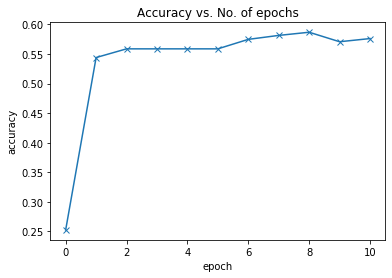

In [154]:
# Replace these values with your results
accuracies = [val_acc] + metrics1 + metrics2
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Our current model outperforms the logistic regression model (which could only reach around 86% accuracy) by a huge margin! It quickly reaches an accuracy of 96%, but doesn't improve much beyond this. To improve the accuracy further, we need to make the model more powerful. As you can probably guess, this can be achieved by increasing the size of the hidden layer, or adding more hidden layers. I encourage you to try out both these approaches and see which one works better.

In [156]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, 
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 1.0026, Accuracy: 0.5762


Now we move onto the test set.

In [158]:
test_time_series = pd.read_csv('test_time_series.csv',index_col = 'timestamp')

test_labels = pd.read_csv('test_labels.csv',index_col = 'timestamp')

test_with_labels = pd.concat([test_time_series,test_labels],axis=1)

In [163]:
test_with_labels = test_with_labels.dropna(subset = ['label'])

In [167]:
classification_target = 'label'
all_covariates = ['x','y','z']

targets_test = np.array(test_with_labels.label,dtype='float32')-1
inputs_test = np.array(test_with_labels[all_covariates],dtype='float32')


inputs_test = torch.from_numpy(inputs_test)
targets_test = torch.from_numpy(targets_test)

targets_test = targets_test.long()

In [178]:
model(inputs_test)

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #4 'mat1'

In [169]:
dataset_test = TensorDataset(inputs_test, targets_test)

In [171]:
test_dl = DataLoader(dataset_test,
                    batch_size)

In [ ]:


with torch.no_grad():
    predictions = []
    for feature, labels in test_dl:
        feature = feature.to(device)  # missing line from original code
        labels = labels.to(device)  # missing line from original code
        out = model(feature)
        _, predicted = torch.max(out.data, 1)
        predictions+=predicted.tolist()
print(predictions)

In [187]:
test_dl = DeviceDataLoader(test_dl, device)

In [177]:
test_loss, total, test_acc = evaluate(model, F.cross_entropy, 
                                    test_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 0.6311, Accuracy: 0.8640


## Commit and upload the notebook

As a final step, we can save and commit our work using the jovian library.

In [29]:
!pip install jovian --upgrade -q

In [30]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit()

[jovian] Saving notebook..


<IPython.core.display.Javascript object>

## Summary and Further Reading

Here is a summary of the topics covered in this tutorial:

* We created a neural network with one hidden layer to improve upon the logistic regression model from the previous tutorial. We also used the ReLU activation function to introduce non-linearity into the model, allowing it to learn more complex relationships between the inputs (pixel densities) and outputs (class probabilities).

* We defined some utilities like `get_default_device`, `to_device` and `DeviceDataLoader` to leverage a GPU if available, by moving the input data and model parameters to the appropriate device.

* We were able to use the exact same training loop: the `fit` function we had define earlier to train out model and evaluate it using the validation dataset.

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:

* Try changing the size of the hidden layer, or add more hidden layers and see if you can achieve a higher accuracy.

* Try changing the batch size and learning rate to see if you can achieve the same accuracy in fewer epochs.

* Compare the training times on a CPU vs. GPU. Do you see a significant difference. How does it vary with the size of the dataset and the size of the model (no. of weights and parameters)?

* Try building a model for a different dataset, such as the [CIFAR10 or CIFAR100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html).

Here are some references for further reading:

* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), also known as the Universal Approximation Theorem.

* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - A visual and intuitive introduction to what neural networks are and what the intermediate layers represent

* [Stanford CS229 Lecture notes on Backpropagation](http://cs229.stanford.edu/notes/cs229-notes-backprop.pdf) - for a more mathematical treatment of how gradients are calculated and weights are updated for neural networks with multiple layers.